# Arbitrage Pricing Theory

Arbitrage Pricing Theory (APT) is a theory of asset pricing. It asserts that the expected return of an asset can be expressed as a linear function of multiple systematic risk factors priced by the market. APT was introduced in 1976 by Stephen Ross and is based on arbitrage arguments.

APT was developed as an alternative to single-factor pricing models such as the Capital Asset Pricing Model (CAPM). These single-factor models do not explicitly explain the cross-section of expected asset returns.

According to APT, multiple factors can be used to explain the expected rate of return on a risky asset. These include:

- Oil and energy prices
- Central Bank interest rates
- Consumer Price Index (CPI)

The following equation explains the expected return of an asset or portfolio given certain factors:

$R_a = R_f + \beta_{1}λ_1+\beta_2λ_2+...+\beta_kλ_k$

Where:
- $R_a$: Expected return of an asset or portfolio.
- $R_f$: Risk-free rate return, usually the return of an AAA Treasury Bond
- $\beta$: Sensitivity for asset relative to factor k.
- $λ$: Risk premium relative to factor k.

## Project Overview

This project focuses on applying an APT model to FedEx stocks and predicting their future returns using related factors such as Brent oil prices, market returns, interest rates, CPI, and others.

The primary objectives include:

- Model Fitting: Construct an APT model using historical stock, market, and macroeconomic data.
- Implementation from scratch: Perform all calculations manually to deepen our understanding of the underlying concepts.

- Evaluation: Assess the fit of the model and determine which factors are significant and are to be included in the final model.



In [ ]:
# Importing libraries
import requests
from google.colab import userdata
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## API calls and data preprocessing

In [ ]:
# Insert your API Key
API_KEY = userdata.get('API_KEY_AV')

In [ ]:
# Functions returning JSON format output from the API calls

def get_asset_data(API_KEY, function, symbol, outputsize='full'):
  url = f'https://www.alphavantage.co/query?function={function}&outputsize={outputsize}&symbol={symbol}&interval=5min&apikey={API_KEY}'
  response = requests.get(url)
  data = response.json()
  return data

def get_risk_free_rate(API_KEY,function='TREASURY_YIELD',interval='daily', maturity= '10year'):
  url = f'https://www.alphavantage.co/query?function={function}&interval={interval}&maturity={maturity}&apikey={API_KEY}'
  response = requests.get(url)
  data = response.json()
  return data
def get_fed_rates(API_KEY, function='FEDERAL_FUNDS_RATE', interval='daily' ):
  url = f'https://www.alphavantage.co/query?function={function}&interval={interval}&apikey={API_KEY}'
  response = requests.get(url)
  data = response.json()
  return data

def get_oil_data(API_KEY,oil_type,interval='daily'):
    url = f'https://www.alphavantage.co/query?function={oil_type}&interval={interval}&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

def get_durables(API_KEY, function='DURABLES'):
    url = f'https://www.alphavantage.co/query?function={function}&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

def get_retail_sales(API_KEY, function='RETAIL_SALES'):
    url = f'https://www.alphavantage.co/query?function={function}&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

def get_cpi(API_KEY, function='CPI', interval='monthly'):
    url = f'https://www.alphavantage.co/query?function={function}&interval={interval}&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

def get_unemployment_rate(API_KEY,function='UNEMPLOYMENT',interval='monthly'):
    url = f'https://www.alphavantage.co/query?function={function}&apikey={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

In [ ]:
# Returns a DataFrame from the previous JSON of each API call.

def data_asset_to_df(API_KEY, asset, market):
    data_asset = get_asset_data(API_KEY,'TIME_SERIES_DAILY',asset)
    market_data = get_asset_data(API_KEY,'TIME_SERIES_DAILY',market)
    df_asset = pd.DataFrame(data_asset['Time Series (Daily)']).T.sort_index()['4. close'].reset_index().rename(columns={'index':'date', '4. close': asset})
    df_market = pd.DataFrame(market_data['Time Series (Daily)']).T.sort_index()['4. close'].reset_index().rename(columns={'index':'date', '4. close':market})
    df = df_asset.merge(df_market)
    return df

def treasury_yields(API_KEY):
    data = get_risk_free_rate(API_KEY)
    df = pd.DataFrame(data['data']).sort_values(by='date').rename(columns={'value': 'RiskFreeRate'})
    return df

def fed_rates(API_KEY):
  data = get_fed_rates(API_KEY)
  df = pd.DataFrame(data['data']).sort_values(by='date').rename(columns={'value':'FED_INTEREST_RATE'})
  return df

def oil_data_to_df(API_KEY, oil_type):
    data = get_oil_data(API_KEY,oil_type)
    df = pd.DataFrame(data['data'][::-1]).rename(columns={'value':oil_type})
    return df

def durables_to_df(API_KEY):
    data = get_durables(API_KEY)
    df = pd.DataFrame(data['data'][::-1]).rename(columns={'value': 'DURABLES'})
    return df

def retails_to_df(API_KEY):
    data = get_retail_sales(API_KEY)
    df = pd.DataFrame(data['data'][::-1]).rename(columns={'value': 'RETAILS SALES'})
    return df

def cpi_to_df(API_KEY):
    data = get_cpi(API_KEY)
    df = pd.DataFrame(data['data'][::-1]).rename(columns={'value': 'CPI'})
    return df

def unemployment_to_df(API_KEY):
    data = get_unemployment_rate(API_KEY)
    df = pd.DataFrame(data['data'][::-1]).rename(columns={'value': 'UNEMPLOYMENT'})
    return df

In [ ]:
# Get all necessary dataframes for the analysis
df1 = data_asset_to_df(API_KEY, 'FDX', 'SPY')
df2 = treasury_yields(API_KEY)
df3 = fed_rates(API_KEY)
df4 = oil_data_to_df(API_KEY, 'BRENT')
df5 = durables_to_df(API_KEY)
df6 = retails_to_df(API_KEY)
df7 = cpi_to_df(API_KEY)
df8 = unemployment_to_df(API_KEY)

In [ ]:
# Combine all dataframes and transform the data to reflect the percentage changes of every indicator
df = df1.merge(df2).merge(df3).merge(df4).merge(df5, how='left').merge(df6,how='left').merge(df7, how='left').merge(df8,how='left')

for column in df.columns:
  if column == 'date':
    df[column] = pd.to_datetime(df[column])
  else:
    df[column] = df[column].apply(lambda x: np.nan if x == '.' else x)
    df[column] = pd.to_numeric(df[column]).interpolate()
    if column == 'RiskFreeRate':
      df[column] = ((1 + df[column] / 100) ** (1/252) -1)
    else:
      df[column] = pd.to_numeric(df[column]).pct_change()
df = df.dropna()

In [ ]:
df.describe()

,date,FDX,SPY,RiskFreeRate,FED_INTEREST_RATE,BRENT,DURABLES,RETAILS SALES,CPI,UNEMPLOYMENT
count,6497,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,2012-10-01 02:13:25.664152576,0.000462,0.000314,0.000130,0.003624,0.000516,0.000074,0.000160,0.000100,0.000010
min,1999-11-02 00:00:00,-0.214038,-0.109424,0.000021,-0.772727,-0.474654,-0.014479,-0.007953,-0.000718,-0.009901
25%,2006-04-20 00:00:00,-0.009404,-0.004829,0.000088,0.000000,-0.011461,-0.002376,-0.001452,0.000008,-0.000784
50%,2012-09-28 00:00:00,0.000207,0.000633,0.000133,0.000000,0.000796,-0.000399,0.000093,0.000088,0.000000
75%,2019-03-18 00:00:00,0.010110,0.005994,0.000168,0.000000,0.012762,0.002131,0.001180,0.000202,0.000551
max,2025-09-02 00:00:00,0.155277,0.145198,0.000261,3.125000,0.509868,0.012806,0.014796,0.000703,0.030205
std,NaN,0.020052,0.012267,0.000051,0.096283,0.025829,0.003738,0.003269,0.000164,0.002345


## Data Exploration


FDX
Mean:0.0004615542546007448
Standard Deviation: 0.020051952145975358


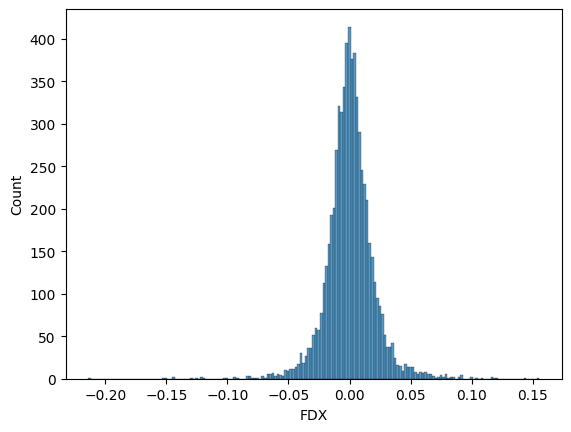


SPY
Mean:0.0003142319170479823
Standard Deviation: 0.012266777072187391


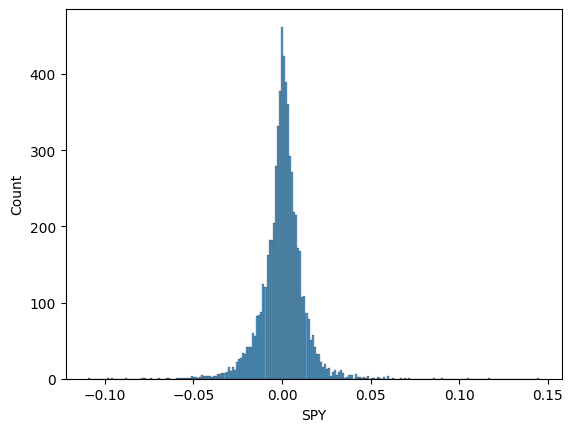


RiskFreeRate
Mean:0.00012964809573033553
Standard Deviation: 5.0524247464868976e-05


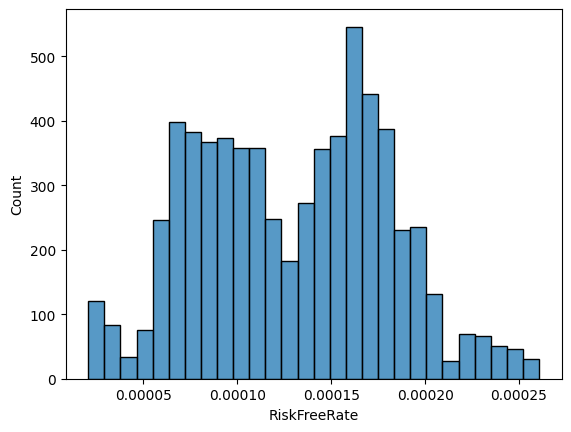


FED_INTEREST_RATE
Mean:0.003623810919891435
Standard Deviation: 0.0962828306087561


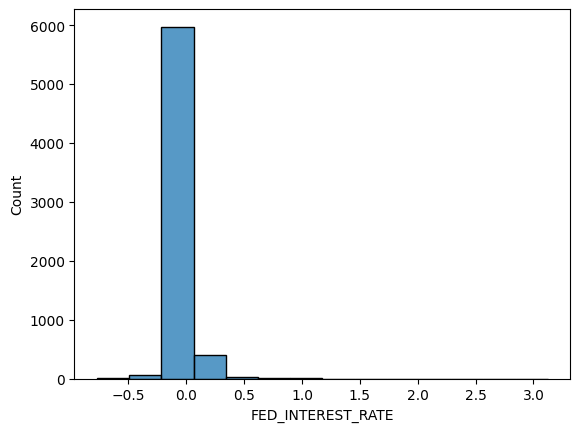


BRENT
Mean:0.0005160361627215307
Standard Deviation: 0.025829087858088632


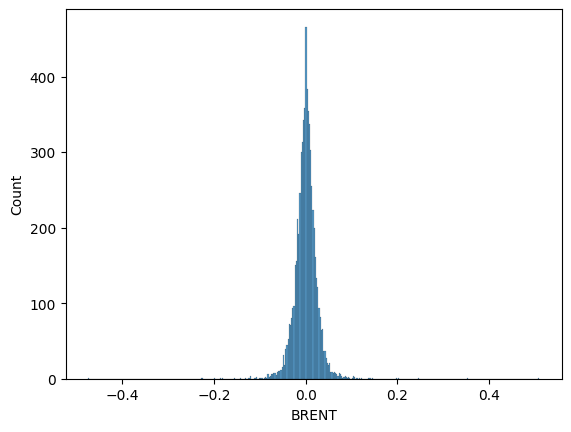


DURABLES
Mean:7.41406599165709e-05
Standard Deviation: 0.0037378468973194895


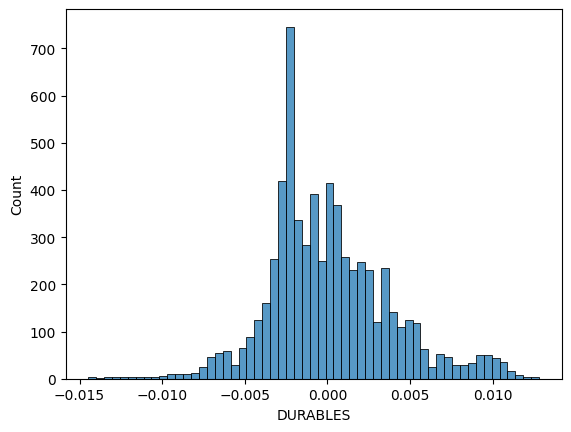


RETAILS SALES
Mean:0.000160423678570208
Standard Deviation: 0.0032691465837976323


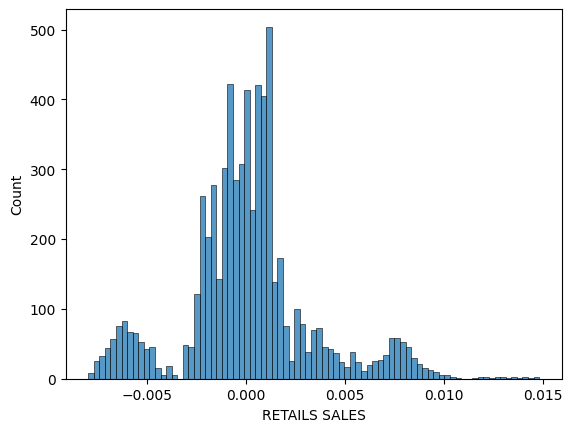


CPI
Mean:0.00010038066285708534
Standard Deviation: 0.0001642574138935885


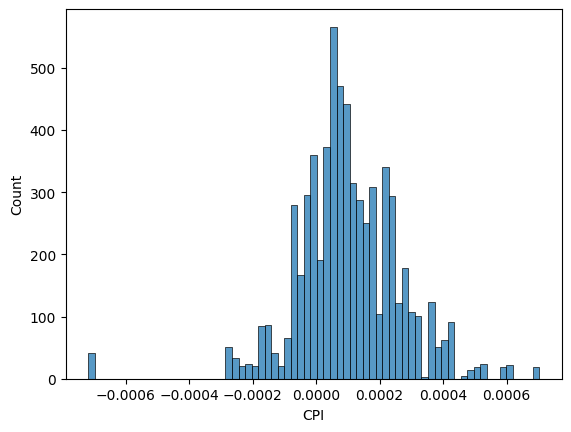


UNEMPLOYMENT
Mean:1.0059137539063146e-05
Standard Deviation: 0.0023448867507227674


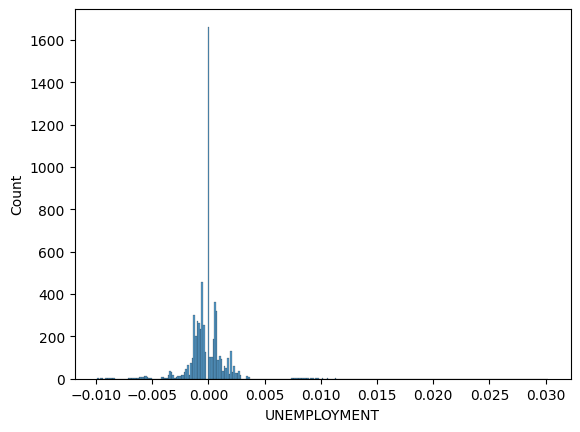

In [ ]:
for column in df.columns:
  if column != 'date':
        sns.histplot(data=df, x=column)
        print(f'\n{column}\nMean:{df[column].mean()}\nStandard Deviation: {df[column].std()}')
        plt.show()

Most variables seem to follow a normal distribution, therefore, Student t-test will be our primary testing method due to the large sample size and/or continuous numerical data.

## Multiple linear regression

Let's recall the equation for a simple linear equation:

$y=a + βx$

$\beta=\frac{cov(x,y)}{var(x)}=\frac{(x_i-\overline{x})(y_i-\overline{y})}{(x_i-\overline{x})²}$

$a= y-βx$

Another way to compute a linear regression is by Linear Algebra with the following equation:

$(X^TX)^{-1}c=X^Ty$

Where

$X = \begin{bmatrix}
   1 & X_{11} & X_{12} & \dots & X_{1k} \\
   1 & X_{21} & X_{22}   & \dots & X_{2k} \\
   \vdots & \vdots & \vdots & \vdots & \vdots\\
   1 & X_{n1} & X_{n2}   & \dots & X_{nk} \\
   \end{bmatrix}$

which is an $n × (k+1)$ matrix composed of $n$ observations and $k$ independent factors (including a column of ones for the intercept).

- $c$ is the vector of coefficients (intercept and slopes).
- $y$ is the dependent variable, which in this case is the asset return minus the risk-free rate.


Solving for $c$ we get:

$c=(X^TX)^{-1}X^Ty$

This formula provides the coefficients needed to compute a linear regression with one or more factors.

In [ ]:
# Compute market and asset returns adjusted by risk
df['FDX_adj']= df['FDX']-df['RiskFreeRate']
df['SPY_adj'] = df['SPY'] - df['RiskFreeRate']

# Compute the linear regression returning all factors coefficients and predicting future dependent values
predictors = ['SPY_adj','FED_INTEREST_RATE', 'BRENT', 'DURABLES','RETAILS SALES', 'CPI','UNEMPLOYMENT']
X = df[predictors]
y = df['FDX_adj']

def linear_regression(predictor_values,predicted_values):
   if predictor_values.ndim == 1:
     X = predictor_values.values.reshape(-1,1)
   else:
     X = predictor_values

   X = np.hstack((np.ones((X.shape[0],1)),X))
   y = predicted_values

   coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
   prediction = df['RiskFreeRate']+X[0:,1:].dot(coefficients[1:])

   return coefficients,prediction

coefficients, prediction = linear_regression(X,y)

df['FDX_FORECAST'] = prediction
print(coefficients, '\n')
display(df.head())

[ 3.73961682e-04  1.00332390e+00  2.74287328e-03 -2.28119692e-02
 -4.84915784e-02  1.19027061e-01 -2.38863349e+00 -1.14093590e-01] 



,date,FDX,SPY,RiskFreeRate,FED_INTEREST_RATE,BRENT,DURABLES,RETAILS SALES,CPI,UNEMPLOYMENT,FDX_adj,SPY_adj,FDX_FORECAST
1,1999-11-02,0.007470,-0.007147,0.000233,-0.037175,0.030957,0.004838,0.010286,0.0,-0.001161,0.007237,-0.007379,-0.006857
2,1999-11-03,-0.008850,0.006734,0.000232,0.005792,0.018198,0.004814,0.010181,0.0,-0.001163,-0.009081,0.006502,0.007467
3,1999-11-04,-0.016651,0.007610,0.000229,0.011516,0.011618,0.004791,0.010078,0.0,-0.001164,-0.016880,0.007381,0.008502
4,1999-11-05,0.027730,0.009842,0.000228,-0.024668,0.007067,0.004768,0.009978,0.0,-0.001166,0.027502,0.009614,0.010735
5,1999-11-08,0.058023,0.000907,0.000229,0.017510,0.035965,0.004746,0.009879,0.0,-0.001167,0.057794,0.000677,0.001215


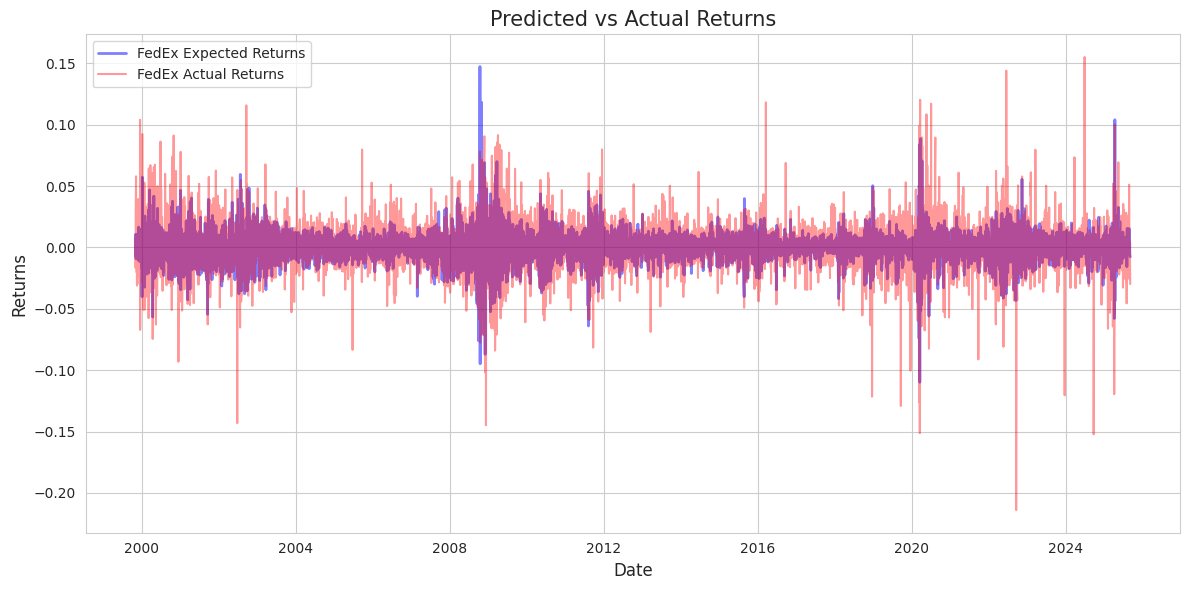

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(x=df['date'],y=df['FDX_FORECAST'], label='FedEx Expected Returns', color='blue', linewidth=2,alpha=0.5)
sns.lineplot(x=df['date'],y=df['FDX'], label='FedEx Actual Returns', color='red', alpha=0.4)

plt.title('Predicted vs Actual Returns', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

In this section relevant metrics for evaluating the linear model will be computed. These metrics include:

$R²=1-\frac{SSR}{SST}$

where

$SSR=\sum_{i=1}^{n}(y_i-\hat{y})$
and
$SST=\sum_{i=1}^{n}(y_i-\overline{y})$


Let us also remember the error measures:

Mean Absolute Error or $MAE=\frac{1}{n}\sum_i^n|y-\hat{y}|$

Mean Square Error or $MSE= \frac{SSR}{n} =\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}) $

Root Mean Square Error or $RMSE=\sqrt{MSE}= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y})}$

In addition to these metrics, it is recommended to evaluate the significance of each coefficient. This step is necessary to assess the impact of a given factor on the model and determine whether it should be retained or discarded. The purpose is to keep the model as simple as possible, avoiding overfitting, excessive resource use, and loss of interpretability.

One such a metric is the adjusted R² coefficient which, unlike traditional R², can decrease when non significant factors are added. Adjusted R² is calculated as follows:

$adj R²=1-\frac{(1-R²)(N-1)}{N-1-k}$

Where N is the number of observations and $k$ the number of explaining factors in the model.


Another way to assess the importance of each factor is through hypothesis testing of each coefficient, using the Student's t-test. The test statistic is calculated as:

$t= \frac{β}{SE}$

Where $\beta$ is a vector of factor coefficients and $SE$ is the standard error of each coefficient.

$SE= \sqrt{diag(MSE(X^TX)^{-1})}$

Finally, AIC and BIC are used to penalize the addition of too many factors in the model.

Both AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) compare the quality of different statistical models and select the best one, balancing between underfitting and overfitting. The following equations compute these metrics (the smaller the value, the better the model):

$AIC = 2k -2log(LL)$

$BIC=klog(n) - 2log(LL)$

Where:

$k$: is the number of factors in the model

$n$: is the number of observations in the dataset

$LL$: is the Likelihood of the fit

Given that the likelihood approach can make this exercise too complex for our objectives, we will use the alternative formulas:

$AIC = 2k +n*log(MSE)$

$BIC = klog(n) +n*log(MSE)$


In [ ]:
# Compute model evaluation metrics:

def get_r2_coef(X, y):
    coef, prediction = linear_regression(X,y)
    SR = sum((y - prediction)**2)
    St = sum((y - (y).mean())**2)
    r_2 = 1-(SR/St)

    return r_2

def get_adj_r2_coef(X,y):
  r2 = get_r2_coef(X,y)
  p = X.shape[1]
  n = len(y)
  adj_r2 = 1-(((1-r2)*(n-1))/(n-1-p))
  return adj_r2

def get_errors(X,y):
      coef, prediction = linear_regression(X,y)
      n = len(y)
      k = len(coef)
      SR = float(((y-prediction)**2).sum())
      MAE = float(abs(y-prediction).mean())
      MSE = float(SR/(n-k))
      RMSE = float(np.sqrt(MSE))

      return {'SR':SR,'MAE':MAE,'MSE':MSE,'RMSE': RMSE}

def coef_standard_error_tvalue(X,y):

   n = len(y)
   coefficients,prediction = linear_regression(X,y)
   MSE = get_errors(X,y)['MSE']
   columns = ['Intercept'] + [col for col in X.columns]

   if X.ndim == 1:
     X = X.values.reshape(-1,1)
   else:
     X = X.values

   X = np.hstack((np.ones((X.shape[0],1)),X))

   xtx = np.linalg.inv(X.T.dot(X))
   cov_matrix = MSE* xtx


   SE = np.sqrt(np.diag(cov_matrix))
   t_score = coefficients/SE

   se_dict = dict(zip(columns, [float(x) for x in SE]))
   t_scores = dict(zip(columns, [float(x) for x in t_score]))

   return (se_dict, t_scores)

def AIC(X,y):
  coefficients, prediction = linear_regression(X,y)
  MSE = get_errors(y,prediction)['MSE']
  k = len(coefficients)
  n = len(y)
  AIC = 2*k + n*np.log(MSE)
  return AIC

def BIC(X,y):
  coefficients, prediction = linear_regression(X,y)
  MSE = get_errors(y,prediction)['MSE']
  k = len(coefficients)
  n = len(y)
  BIC = k*np.log(n)+ n*np.log(MSE)
  return BIC


r_2 = get_r2_coef(X,y)
adj_r2 = get_adj_r2_coef(X,y)
errors = get_errors(X, y)
SE, t_scores = coef_standard_error_tvalue(X, y)
get_aic = AIC(X,y)
get_bic = BIC(X,y)

print(f'R² Coeficient: {r_2}')

print(f'Adjusted R² Coeficient: {adj_r2}\n')

print('Error Metrics')
display(errors)

print('\nT-Statistics')
display(t_scores)

R² Coeficient: 0.37212912531070397
Adjusted R² Coeficient: 0.3714518104512765

Error Metrics


{'SR': 1.6399847103789003,
 'MAE': 0.010348152051709957,
 'MSE': 0.00025273304212958855,
 'RMSE': 0.015897579756981518}


T-Statistics


{'Intercept': 1.5960528079190008,
 'SPY_adj': 61.44263057036438,
 'FED_INTEREST_RATE': 1.33776650338585,
 'BRENT': -2.9233136336849506,
 'DURABLES': -0.8126687743262375,
 'RETAILS SALES': 1.7493244984479592,
 'CPI': -1.9221283076390094,
 'UNEMPLOYMENT': -1.3124380494343066}

Adjusted R² is approximately 0.37, which is slightly lower than the actual R² coeficient. This might indicate the presence of non-relevant features in the model, which can be addresed through hypothesis testing.

The T-statistics below provide insight into which variables are significant. For example, if the absolute value of a T-statistic is below 1.96, it means that the variable is not significant at the 95% confidence level.

Some may ask: "Why bother with selecting variables? Just include them all." However, it is best to keep the model as simple as possible, not only to ease interpretation but also to improve computational efficiency.

There are three common ways to perform variable selection:

- **Forward Selection:** Start with one variable and keep adding significant variables step by step.
- **Backward Elimination:** Start with all variables and iteratively remove the least significant ones.
- **Stepwise Regression:** A combination of both forward selection and backward elimination, adding and removing variables as needed.

In the next section, we will explore the Forward Selection method in detail.



## Forward Selection

For any of our methods it is necessary to run the model with each independent variable separately and choose the best one as the first predictor. In this case we will add the predictor with the highest R² coeficient, provided this predictor is statistically significant.


In [ ]:
def linear_model(X,y):
    r2 = get_r2_coef(X,y)
    adj_r2 = get_adj_r2_coef(X,y)
    errors = get_errors(X,y)
    SE, t_stat = coef_standard_error_tvalue(X,y)

    errors = {k: v for k,v in errors.items()}
    SE = {k: v for k,v in SE.items()}
    t_stat = {k: v for k,v in t_stat.items()}


    calc_aic = float(AIC(X,y))
    calc_bic = float(BIC(X,y))

    model = {'R2':r2, 'Adj_R2':adj_r2 , 'Errors': errors, 'Coefficient Errors':SE, 'T_stat': t_stat, 'AIC':calc_aic, 'BIC': calc_bic}
    return model


def model_significance(model):
    model_significance = dict(adj_R2 = model['Adj_R2'],
                              T_stat = model['T_stat'],
                              AIC = model['AIC'],
                              BIC = model['BIC'])

    return model_significance

The following code will choose the best predictor variable among all available variables for the model. Then, it will perform a hypothesis test to ascertain the significance of the variable. If the variable is significant at a 95% confidence level, it will be kept in the model, and a new model will be fitted by adding the next best variable. If the opposite is true, the process will end, and the final model will consist of the variables kept so far.

First, we fit the model with each variable independently:

In [ ]:
predictors = ['SPY_adj','FED_INTEREST_RATE', 'BRENT', 'DURABLES','RETAILS SALES', 'CPI','UNEMPLOYMENT']
X = df[predictors]

def get_best_variable(X, y, fit=None):

    kpis = []
    for predictor in predictors:
      lm = linear_model(X[[predictor]],y) if fit ==None else linear_model(X[fit + [predictor]],y)
      model_kpi = model_significance(lm)
      kpi = {predictor:model_kpi}
      kpis.append(kpi)


    variables = []
    r2s = []

    for kpi in kpis:
      for k,v in kpi.items():
        r2 = v['adj_R2']
        r2s.append(r2)
        variables.append(k)

    best_variable = variables[r2s.index(max(r2s))]

    for i in kpis:
      if best_variable in i.keys():
        significant = np.abs(i[best_variable]['T_stat'][best_variable]) > 1.96

    return best_variable,significant

best_variable,significant = get_best_variable(X=X,y=y)
print('Highest R² Variable: '+best_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')


predictors.remove(best_variable)
fit = [best_variable]

print('\nModel fit')
lm = linear_model(X[fit],y)
lm

Highest R² Variable: SPY_adj
Variable is significant at 95% CL

Model fit


{'R2': 0.3702419327568598,
 'Adj_R2': 0.3701449723154059,
 'Errors': {'SR': 1.6449140152067074,
  'MAE': 0.010370475079424513,
  'MSE': 0.0002532585088847894,
  'RMSE': 0.0159140978030421},
 'Coefficient Errors': {'Intercept': 0.00019745800866501762,
  'SPY_adj': 0.016095365719546322},
 'T_stat': {'Intercept': 0.7511681480167309, 'SPY_adj': 61.792475856863874},
 'AIC': -60253.582508232386,
 'BIC': -60240.02431661062}

It seems that market risk is the most significant variable for predicting asset returns. The t-value is over 61, which makes it significant at well beyond the 95% confidence level, and it has an R² of 0.37. This suggests that market risk might be the only significant risk factor for our asset, more so than any other macroeconomic indicator.

In [ ]:
best_variable,significant = get_best_variable(X=X,y=y,fit=fit)
print('Highest R² Variable: '+best_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(best_variable)
fit.append(best_variable)

print('\nModel fit')
lm = linear_model(X[fit],y)
lm

Highest R² Variable: BRENT
Variable is significant at 95% CL

Model fit


{'R2': 0.3711267762317476,
 'Adj_R2': 0.3709330979983727,
 'Errors': {'SR': 1.6426028238003332,
  'MAE': 0.010365888779427415,
  'MSE': 0.0002529416113027923,
  'RMSE': 0.0159041381817058},
 'Coefficient Errors': {'Intercept': 0.00019736516288059483,
  'SPY_adj': 0.016329712700856605,
  'BRENT': 0.007755818547220898},
 'T_stat': {'Intercept': 0.8048811211523328,
  'SPY_adj': 61.426921900979615,
  'BRENT': -3.0238767620081037},
 'AIC': -60245.286480099174,
 'BIC': -60224.94919266653}

The next variable added to the model is the percentage change of Brent oil prices. Notice that both AIC and BIC metrics have slightly increased with the addition of this new factor, indicating that we might be adding complexity to the model. Although both our R² and Adjusted R² have improved and errors have decreased, the overall metrics remain almost the same. It is the analyst's task to decide whether it is best to keep the model as is, collect more data to justify adding another variable, or continue adding predictors to achieve a better fit.

The next feature selection method is Backward Elimination. In this approach, we start by running the model with all variables and then iteratively delete those whose removal improves the model quality.

##Backward Elimination


This procedure is the opposite of the forward selection method. Here, we fit the model with all available variables and iteratively remove the least important one—typically the factor that contributes the least to R² and is not significant at the 95% confidence level.

The following function selects the worst variable in the model and flags whether it is significant or not.

In [ ]:
predictors = ['SPY_adj','FED_INTEREST_RATE', 'BRENT', 'DURABLES','RETAILS SALES', 'CPI','UNEMPLOYMENT']
X = df[predictors]

def get_worst_variable(X,y):

    lm = linear_model(X,y)
    fullr2= lm['R2']

    coef = []

    for predictor in predictors:
        predictors_temp = [p for p in predictors if p != predictor]
        r2 = linear_model(X[predictors_temp], y)['R2']
        coef.append(fullr2 - r2)


    r2_predictor = dict(zip(predictors,coef))
    min_r2 = min(r2_predictor, key=r2_predictor.get)
    significant = np.abs(lm['T_stat'][min_r2]) >= 1.96

    return min_r2, significant,r2_predictor


lm = linear_model(X[predictors],y)
lm

{'R2': 0.37212912531070397,
 'Adj_R2': 0.3714518104512765,
 'Errors': {'SR': 1.6399847103789003,
  'MAE': 0.010348152051709957,
  'MSE': 0.00025273304212958855,
  'RMSE': 0.015897579756981518},
 'Coefficient Errors': {'Intercept': 0.00023430407794032172,
  'SPY_adj': 0.01632944242994567,
  'FED_INTEREST_RATE': 0.0020503378344636893,
  'BRENT': 0.007803462810484709,
  'DURABLES': 0.059669548005421985,
  'RETAILS SALES': 0.06804172764706408,
  'CPI': 1.24270241575617,
  'UNEMPLOYMENT': 0.08693255275591551},
 'T_stat': {'Intercept': 1.5960528079190008,
  'SPY_adj': 61.44263057036438,
  'FED_INTEREST_RATE': 1.33776650338585,
  'BRENT': -2.9233136336849506,
  'DURABLES': -0.8126687743262375,
  'RETAILS SALES': 1.7493244984479592,
  'CPI': -1.9221283076390094,
  'UNEMPLOYMENT': -1.3124380494343066},
 'AIC': -60225.430941574334,
 'BIC': -60171.19817508729}

Above, we have the model fit and evaluation metrics with every available variable included. At first glance, the factor 'DURABLES' has the lowest t-statistic and could be the first candidate to be removed from the model.

In [ ]:
worst_variable, significant,contribution = get_worst_variable(X,y)

print('Lowest R² Variable: '+worst_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(worst_variable)
print('\nModel fit')
lm = linear_model(X[predictors],y)
display(lm)

print('\nR² contribution by variable')
display(contribution)

Lowest R² Variable: DURABLES
Variable is not significant at 95% CL

Model fit


{'R2': 0.3720449002598666,
 'Adj_R2': 0.3714643562539435,
 'Errors': {'SR': 1.6402047043317536,
  'MAE': 0.010349566706806883,
  'MSE': 0.0002527279975857864,
  'RMSE': 0.0158974210985866},
 'Coefficient Errors': {'Intercept': 0.00023346961778621114,
  'SPY_adj': 0.016329257766624673,
  'FED_INTEREST_RATE': 0.0020500784622894115,
  'BRENT': 0.0078033667577895975,
  'RETAILS SALES': 0.061688707244103566,
  'CPI': 1.227005520148283,
  'UNEMPLOYMENT': 0.08625761373532077},
 'T_stat': {'Intercept': 1.6704322343112883,
  'SPY_adj': 61.442000674490714,
  'FED_INTEREST_RATE': 1.3503430538161438,
  'BRENT': -2.925103561533598,
  'RETAILS SALES': 1.551298590593865,
  'CPI': -2.0770729995885806,
  'UNEMPLOYMENT': -1.2209107093612177},
 'AIC': -60227.500487245845,
 'BIC': -60180.04681656968}


R² contribution by variable


{'SPY_adj': 0.3655471358004092,
 'FED_INTEREST_RATE': 0.00018697776924114784,
 'BRENT': 0.0008611230031668748,
 'DURABLES': 8.422505083738319e-05,
 'RETAILS SALES': 0.00037174849295962265,
 'CPI': 0.00021070138366829916,
 'UNEMPLOYMENT': 0.0001471883185002465}

The DURABLES factor has the lowest R² contribution and is also not significant. Therefore, it will be removed from the model. There are other variables that, a priori, should also be considered for removal due to the low R² and lack of significance. By deleting factors in the model the AIC and BIC will decrease, meaning that the model is becoming simpler diminishing the risk of overfitting.

It is also possible to fit the model multiple times to iteratively choose which predictors to remove following the backward elimination procedure. This process can be implemented by running the code as follows:

In [ ]:
worst_variable, significant,contribution = get_worst_variable(X,y)

print('Lowest R² Variable: '+worst_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(worst_variable)
print('\nModel fit')
lm = linear_model(X[predictors],y)
display(lm)

print('\nR² contribution by variable')
display(contribution)

Lowest R² Variable: UNEMPLOYMENT
Variable is not significant at 95% CL

Model fit


{'R2': 0.3719243567668471,
 'Adj_R2': 0.37144055177282986,
 'Errors': {'SR': 1.640519561244945,
  'MAE': 0.010351617083867842,
  'MSE': 0.000252737569133407,
  'RMSE': 0.015897722136627216},
 'Coefficient Errors': {'Intercept': 0.00023257658545013115,
  'SPY_adj': 0.01632843783989106,
  'FED_INTEREST_RATE': 0.0020495946078515504,
  'BRENT': 0.007798346089472999,
  'RETAILS SALES': 0.060727308353371354,
  'CPI': 1.2145914388063108},
 'T_stat': {'Intercept': 1.5694888010165131,
  'SPY_adj': 61.459444168743715,
  'FED_INTEREST_RATE': 1.3782358715107832,
  'BRENT': -2.8825297013137003,
  'RETAILS SALES': 1.7940948092823563,
  'CPI': -1.9231371108195046},
 'AIC': -60231.111016171155,
 'BIC': -60190.43644130587}


R² contribution by variable


{'SPY_adj': 0.3656234677339556,
 'FED_INTEREST_RATE': 0.00027598653491955893,
 'BRENT': 0.0009486015276471971,
 'RETAILS SALES': 0.0003732759271150021,
 'CPI': 0.000334984124462423,
 'UNEMPLOYMENT': 0.00020476854385687027}

In [ ]:
worst_variable, significant,contribution = get_worst_variable(X,y)

print('Lowest R² Variable: '+worst_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(worst_variable)
print('\nModel fit')
lm = linear_model(X[predictors],y)
display(lm)

print('\nR² contribution by variable')
display(contribution)

Lowest R² Variable: FED_INTEREST_RATE
Variable is not significant at 95% CL

Model fit


{'R2': 0.3717268649921789,
 'Adj_R2': 0.3713397589324082,
 'Errors': {'SR': 1.641035405352289,
  'MAE': 0.010350157811453353,
  'MSE': 0.0002527780969427432,
  'RMSE': 0.01589899672755307},
 'Coefficient Errors': {'Intercept': 0.00023247302901031024,
  'SPY_adj': 0.01632495371295336,
  'BRENT': 0.0077973577284577095,
  'RETAILS SALES': 0.060729499020149944,
  'CPI': 1.2146887856091428},
 'T_stat': {'Intercept': 1.6148784872405815,
  'SPY_adj': 61.43916272721068,
  'BRENT': -2.854856956220176,
  'RETAILS SALES': 1.7810874492807838,
  'CPI': -1.9233012060631003},
 'AIC': -60234.18871649558,
 'BIC': -60200.293237441176}


R² contribution by variable


{'SPY_adj': 0.3659264512545274,
 'FED_INTEREST_RATE': 0.0004022603185250828,
 'BRENT': 0.0010437361608998108,
 'RETAILS SALES': 0.0005698748947770005,
 'CPI': 0.0004250067181964523}

In [ ]:
worst_variable, significant,contribution = get_worst_variable(X,y)

print('Lowest R² Variable: '+worst_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(worst_variable)
print('\nModel fit')
lm = linear_model(X[predictors],y)
display(lm)

print('\nR² contribution by variable')
display(contribution)

Lowest R² Variable: CPI
Variable is not significant at 95% CL

Model fit


{'R2': 0.3715186923066467,
 'Adj_R2': 0.37122831129277334,
 'Errors': {'SR': 1.641579147760408,
  'MAE': 0.010356289676866071,
  'MSE': 0.0002528229089420003,
  'RMSE': 0.01590040593639044},
 'Coefficient Errors': {'Intercept': 0.00019755081521811432,
  'SPY_adj': 0.016326259619486406,
  'BRENT': 0.007756092460933863,
  'RETAILS SALES': 0.06036625900026484},
 'T_stat': {'Intercept': 0.7070060777299036,
  'SPY_adj': 61.42625405583103,
  'BRENT': -3.0703490499285055,
  'RETAILS SALES': 2.0046577208350764},
 'AIC': -60240.343323336616,
 'BIC': -60213.226940093096}


R² contribution by variable


{'SPY_adj': 0.36592607990021175,
 'BRENT': 0.0012264186632094942,
 'RETAILS SALES': 0.000764431867367521,
 'CPI': 0.0006104330040572759}

In [ ]:
worst_variable, significant,contribution = get_worst_variable(X,y)

print('Lowest R² Variable: '+worst_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(worst_variable)
print('\nModel fit')
lm = linear_model(X[predictors],y)
display(lm)

print('\nR² contribution by variable')
display(contribution)

Lowest R² Variable: RETAILS SALES
Variable is not significant at 95% CL

Model fit


{'R2': 0.3711267762317476,
 'Adj_R2': 0.3709330979983727,
 'Errors': {'SR': 1.6426028238003332,
  'MAE': 0.010365888779427415,
  'MSE': 0.0002529416113027923,
  'RMSE': 0.0159041381817058},
 'Coefficient Errors': {'Intercept': 0.00019736516288059483,
  'SPY_adj': 0.016329712700856605,
  'BRENT': 0.007755818547220898},
 'T_stat': {'Intercept': 0.8048811211523328,
  'SPY_adj': 61.426921900979615,
  'BRENT': -3.0238767620081037},
 'AIC': -60245.286480099174,
 'BIC': -60224.94919266653}


R² contribution by variable


{'SPY_adj': 0.36594017805910606,
 'BRENT': 0.0015233256734057399,
 'RETAILS SALES': 0.001002349078956355}

In [ ]:
worst_variable, significant,contribution = get_worst_variable(X,y)

print('Lowest R² Variable: '+worst_variable)
print('Variable is significant at 95% CL' if significant else 'Variable is not significant at 95% CL')

predictors.remove(worst_variable)
print('\nModel fit')
lm = linear_model(X[predictors],y)
display(lm)

print('\nR² contribution by variable')
display(contribution)

Lowest R² Variable: BRENT
Variable is significant at 95% CL

Model fit


{'R2': 0.3702419327568598,
 'Adj_R2': 0.3701449723154059,
 'Errors': {'SR': 1.6449140152067074,
  'MAE': 0.010370475079424513,
  'MSE': 0.0002532585088847894,
  'RMSE': 0.0159140978030421},
 'Coefficient Errors': {'Intercept': 0.00019745800866501762,
  'SPY_adj': 0.016095365719546322},
 'T_stat': {'Intercept': 0.7511681480167309, 'SPY_adj': 61.792475856863874},
 'AIC': -60253.582508232386,
 'BIC': -60240.02431661062}


R² contribution by variable


{'SPY_adj': 0.36652841105368894, 'BRENT': 0.0018871925538441747}

After running the steps above, the model should retain only one factor: the **SPY_adj** variable. This means that market risk is the only relevant risk factor for FedEx returns—at least based on the given data.

# Conclusion

In this project, we demonstrated how to fit a multiple linear regression model from scratch to explain an asset’s return. New metrics were introduced to evaluate not only the model’s fit but also its complexity and risk of overfitting. Various hypothesis tests were performed to ascertain the significance of each variable. Finally, feature selection was carried out by choosing the best variables using either forward selection or backward elimination methods.

While the model showed that market risk is the most significant predictor, the overall R² remained relatively low, and a fixed volatility assumption was made. This suggests limited explanatory power from other macroeconomic factors with the given data. The analysis underscores the importance of balancing model simplicity with statistical rigor to avoid overfitting.

Future work could explore alternative modeling approaches or incorporate additional data to better capture complex relationships. Nevertheless, this project, along with the previous CAPM project, covered the most relevant topics related to linear regression. It has been a pleasure sharing this knowledge with you, and I hope you found it both useful and engaging.

# Bibliography

https://www.statology.org/standard-error-of-regression-slope/

https://study.com/skill/learn/calculating-an-appropriate-test-statistic-and-p-value-for-the-slope-of-a-regression-model-explanation.html

https://www.statology.org/standard-error-of-regression-slope/

https://robjhyndman.com/hyndsight/lm_aic.html

https://stats.stackexchange.com/questions/27916/standard-errors-for-multiple-regression-coefficients